In [1]:
import math
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Data preprocessing

## Combining data from two data sets
The data came as two separate CSV files. One for tor traffic and one for nonTOR traffic. I combined both into one file that I chose to name combined_csv

## Relabelling Data
Currently, the data set contains alot of labels including AUDIO, BROWSING, VOID, ETC. I only want to differentiate between tor and nontor data.
So I will relabel anything that is not labeled nonTOR to TOR

In [2]:
combined_data = pd.read_csv('./Data/combined_csv.csv')

## Before relabelling

In [3]:
combined_data['label'].value_counts()

nonTOR           119580
TOR               16088
VOIP               4582
BROWSING           3208
P2P                2170
VIDEO              1748
FILE-TRANSFER      1728
AUDIO              1442
CHAT                646
MAIL                564
Name: label, dtype: int64

In [4]:
combined_data['label'] = combined_data['label'].map({'VOIP': 'TOR', 'BROWSING':'TOR', 'P2P':'TOR', 'VIDEO':'TOR', 'FILE-TRANSFER':'TOR', 'AUDIO':'TOR', 'CHAT':'TOR', 'MAIL': 'TOR', 'TOR':'TOR', 'nonTOR':'nonTOR'})
combined_data.head()


,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.8.8.246,64162,8.8.8.8,53,17,119598,1.237479e+03,16.722688,119598.000000,0.000000,...,0,0,0,0,0,0,0,0,0,nonTOR
1,10.8.0.14,42741,173.194.123.3,443,6,9372614,1.076541e+03,7.895343,128391.972603,954949.092507,...,18,39512,0,39512,39512,8168971,0,8168971,8168971,nonTOR
2,131.202.242.93,65485,224.0.0.252,5355,17,411626,1.068932e+02,4.858780,411626.000000,0.000000,...,0,0,0,0,0,0,0,0,0,nonTOR
3,131.202.240.183,63970,255.255.255.255,1900,17,175,1.977143e+06,11428.571429,175.000000,0.000000,...,0,0,0,0,0,0,0,0,0,nonTOR
4,10.8.8.130,22032,198.7.63.141,53,17,124209,2.012737e+03,16.101893,124209.000000,0.000000,...,0,0,0,0,0,0,0,0,0,nonTOR


# After Relabelling

In [5]:
combined_data['label'].value_counts()

nonTOR    119580
TOR        32176
Name: label, dtype: int64

Encode features

# Feature Engineering

We want to encode the labels "TOR" and "nonTOR" from strings to numbers. 


In [6]:
def encodify(dataframe, feature):
    encoder = LabelEncoder()
    encoder.fit(dataframe[feature])
    encoded_feature = encoder.transform(dataframe[feature])
    dataframe[feature] = encoded_feature


In [7]:
discrete_feature_l = ['label']
for feature in discrete_feature_l:
    encodify(combined_data, feature)
    
combined_data

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.8.8.246,64162,8.8.8.8,53,17,119598,1.237479e+03,16.722688,1.195980e+05,0.000000e+00,...,0,0,0,0,0,0,0,0,0,1
1,10.8.0.14,42741,173.194.123.3,443,6,9372614,1.076541e+03,7.895343,1.283920e+05,9.549491e+05,...,18,39512,0,39512,39512,8168971,0,8168971,8168971,1
2,131.202.242.93,65485,224.0.0.252,5355,17,411626,1.068932e+02,4.858780,4.116260e+05,0.000000e+00,...,0,0,0,0,0,0,0,0,0,1
3,131.202.240.183,63970,255.255.255.255,1900,17,175,1.977143e+06,11428.571429,1.750000e+02,0.000000e+00,...,0,0,0,0,0,0,0,0,0,1
4,10.8.8.130,22032,198.7.63.141,53,17,124209,2.012737e+03,16.101893,1.242090e+05,0.000000e+00,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151751,173.194.67.189,443,10.8.8.178,57866,6,7507231,3.983226e+03,19.447916,5.177401e+04,1.214635e+05,...,26,0,0,0,0,0,0,0,0,1
151752,10.0.2.15,58167,195.154.107.23,443,6,9884148,6.322811e+04,100.463894,9.963859e+03,2.515580e+04,...,3,0,0,0,0,0,0,0,0,0
151753,10.8.8.130,49539,151.236.19.39,15685,17,6338782,2.650351e+01,0.946554,1.267756e+06,1.220697e+06,...,0,0,0,0,0,0,0,0,0,1
151754,131.202.243.109,137,131.202.243.255,137,17,1053340,1.898722e+02,3.797444,3.511133e+05,3.328779e+05,...,0,0,0,0,0,0,0,0,0,1


# Data Cleaning

Some of the values in the data set are bigger than what pythons float datatype can handle. I decided to just remove data points that have values that are too large. 

In [8]:
combined_data_filter = combined_data.isin([np.nan, np.inf, -np.inf])
combined_data = combined_data[~combined_data_filter]
combined_data.dropna(inplace=True)
combined_data

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.8.8.246,64162,8.8.8.8,53,17,119598,1.237479e+03,16.722688,1.195980e+05,0.000000e+00,...,0,0,0,0,0,0,0,0,0,1
1,10.8.0.14,42741,173.194.123.3,443,6,9372614,1.076541e+03,7.895343,1.283920e+05,9.549491e+05,...,18,39512,0,39512,39512,8168971,0,8168971,8168971,1
2,131.202.242.93,65485,224.0.0.252,5355,17,411626,1.068932e+02,4.858780,4.116260e+05,0.000000e+00,...,0,0,0,0,0,0,0,0,0,1
3,131.202.240.183,63970,255.255.255.255,1900,17,175,1.977143e+06,11428.571429,1.750000e+02,0.000000e+00,...,0,0,0,0,0,0,0,0,0,1
4,10.8.8.130,22032,198.7.63.141,53,17,124209,2.012737e+03,16.101893,1.242090e+05,0.000000e+00,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151751,173.194.67.189,443,10.8.8.178,57866,6,7507231,3.983226e+03,19.447916,5.177401e+04,1.214635e+05,...,26,0,0,0,0,0,0,0,0,1
151752,10.0.2.15,58167,195.154.107.23,443,6,9884148,6.322811e+04,100.463894,9.963859e+03,2.515580e+04,...,3,0,0,0,0,0,0,0,0,0
151753,10.8.8.130,49539,151.236.19.39,15685,17,6338782,2.650351e+01,0.946554,1.267756e+06,1.220697e+06,...,0,0,0,0,0,0,0,0,0,1
151754,131.202.243.109,137,131.202.243.255,137,17,1053340,1.898722e+02,3.797444,3.511133e+05,3.328779e+05,...,0,0,0,0,0,0,0,0,0,1


# Split the X and Y 

Features will contain all the data points features such as protocol, flow duration, etc. The only features being excluded are Source IP, Source Port, Destination IP, and Destination Port because I dont know if they will be very helpful anyways

In [9]:
features = combined_data.iloc[:,4:28]
labels = combined_data.iloc[:,28]

In [10]:
features.head()

,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Mean,Fwd IAT Std,...,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,17,119598,1.237479e+03,16.722688,119598.000000,0.000000,119598,119598,0.00000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
1,6,9372614,1.076541e+03,7.895343,128391.972603,954949.092507,8168971,9,292094.46875,1.438868e+06,...,144532,18,39512,0,39512,39512,8168971,0,8168971,8168971
2,17,411626,1.068932e+02,4.858780,411626.000000,0.000000,411626,411626,411626.00000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
3,17,175,1.977143e+06,11428.571429,175.000000,0.000000,175,175,175.00000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
4,17,124209,2.012737e+03,16.101893,124209.000000,0.000000,124209,124209,0.00000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .20)

1 Corresponds to nonTor Data and 0 corresponds to Tor data

In [12]:
y_train.value_counts()

1    95631
0    25764
Name: label, dtype: int64

Text(0, 0.5, 'Frequency')

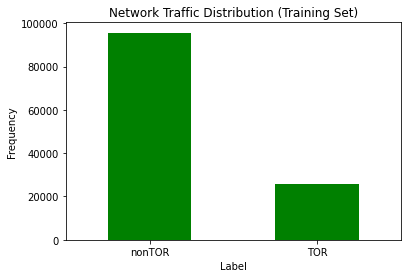

In [13]:
label_l = ['nonTOR', 'TOR']
classes = pd.value_counts(y_train,)
classes.plot(kind = 'bar', rot = 0, color = "green")
plt.title("Network Traffic Distribution (Training Set)")
plt.xticks(range(2), label_l)
plt.xlabel("Label")
plt.ylabel("Frequency")

In [14]:
y_test.value_counts()

1    23937
0     6412
Name: label, dtype: int64

Text(0, 0.5, 'Frequency')

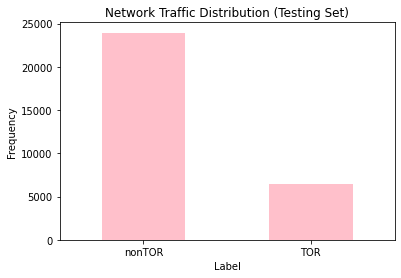

In [15]:
label_l = ['nonTOR', 'TOR']
classes = pd.value_counts(y_test,)
classes.plot(kind = 'bar', rot = 0, color = "pink")
plt.title("Network Traffic Distribution (Testing Set)")
plt.xticks(range(2), label_l)
plt.xlabel("Label")
plt.ylabel("Frequency")

# Model training and testing



In [16]:
model = KNeighborsClassifier(n_neighbors=4,p=1 )
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, p=1)

In [17]:
Accuracy = model.score(X_test, y_test)

/home/jonathan1/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [18]:
print(Accuracy)

0.9740683383307522
